# UCI HAR Dataset – Gait-Based Person Identification

This notebook validates our gait-based person identification approach 
using the UCI Human Activity Recognition dataset.

Goal:
- Identify individuals using accelerometer + gyroscope signals
- Use only walking activities
- Extract time-domain and frequency-domain features
- Train a Random Forest classifier
- Evaluate accuracy, precision, recall, F1-score, and confusion matrix

This serves as benchmark validation before testing on real-world data.


In [14]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)


In [15]:
##Load Accelerometer Data

base_path = "../UCI HAR Dataset/train/Inertial Signals/"

acc_x = np.loadtxt(base_path + "body_acc_x_train.txt")
acc_y = np.loadtxt(base_path + "body_acc_y_train.txt")
acc_z = np.loadtxt(base_path + "body_acc_z_train.txt")

print("Accelerometer shape:", acc_x.shape)


Accelerometer shape: (7352, 128)


In [16]:
##Load Gyroscope Data

gyro_x = np.loadtxt(base_path + "body_gyro_x_train.txt")
gyro_y = np.loadtxt(base_path + "body_gyro_y_train.txt")
gyro_z = np.loadtxt(base_path + "body_gyro_z_train.txt")

print("Gyroscope shape:", gyro_x.shape)


Gyroscope shape: (7352, 128)


In [17]:
##Load Subject IDs

subjects = np.loadtxt(
    "../UCI HAR Dataset/train/subject_train.txt"
).astype(int)

print("Total samples:", len(subjects))
print("Unique subjects:", len(np.unique(subjects)))


Total samples: 7352
Unique subjects: 21


In [18]:
##Load Activity Labels

activities = np.loadtxt(
    "../UCI HAR Dataset/train/y_train.txt"
).astype(int)

print("Unique activities:", np.unique(activities))


Unique activities: [1 2 3 4 5 6]


## Selecting Only Walking Activities

We use:
- 1 = WALKING
- 2 = WALKING_UPSTAIRS
- 3 = WALKING_DOWNSTAIRS

Because gait identification is meaningful only during walking.


In [19]:
##Filter Walking Data

walking_mask = np.isin(activities, [1, 2, 3])

print("Walking samples:", np.sum(walking_mask))


Walking samples: 3285


In [20]:
##Compute Magnitude

acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
gyro_mag = np.sqrt(gyro_x**2 + gyro_y**2 + gyro_z**2)


In [21]:
##Feature Extraction

def gait_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    rms = np.sqrt(np.mean(signal**2))
    ptp = np.ptp(signal)

    fft_vals = np.abs(fft(signal))
    fft_vals = fft_vals[:len(fft_vals)//2]

    dom_freq = np.argmax(fft_vals)
    spec_energy = np.sum(fft_vals**2)
    freq_std = np.std(fft_vals)

    return [mean, std, rms, ptp, dom_freq, spec_energy, freq_std]


In [22]:
##Build Feature Matrix

X_features = []
y_labels = []

for i in range(len(acc_x)):
    if not walking_mask[i]:
        continue

    features = []

    features += gait_features(acc_x[i])
    features += gait_features(acc_y[i])
    features += gait_features(acc_z[i])
    features += gait_features(acc_mag[i])

    features += gait_features(gyro_x[i])
    features += gait_features(gyro_y[i])
    features += gait_features(gyro_z[i])
    features += gait_features(gyro_mag[i])

    X_features.append(features)
    y_labels.append(subjects[i])

X = np.array(X_features)
y = np.array(y_labels)

print("Feature matrix shape:", X.shape)
print("Unique subjects:", len(np.unique(y)))


Feature matrix shape: (3285, 56)
Unique subjects: 21


## Here Training : Test Ratio is 80:20 
and further in README.md results achived during 70:30 and 60:40 ratio were also mentioned

In [23]:
##Train Validation Split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42,
    stratify=y
)


In [24]:
##Scaling

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)


In [25]:
##Train Random Forest

model = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_s, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [26]:
##Evaluation Metrics

y_pred = model.predict(X_val_s)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average="macro")
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print("FINAL VALIDATION METRICS (ACC + GYRO)")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)


FINAL VALIDATION METRICS (ACC + GYRO)
Accuracy : 0.8812785388127854
Precision: 0.88212679502584
Recall   : 0.8794768387647361
F1 Score : 0.8787035127692


In [ ]:
##Classification Report

print("\nDetailed Classification Report:\n")
print(classification_report(y_val, y_pred))



Detailed Classification Report:

              precision    recall  f1-score   support

           1       0.93      0.97      0.95        39
           3       0.85      0.88      0.87        33
           5       0.76      0.97      0.85        30
           6       0.96      0.87      0.92        31
           7       0.93      0.90      0.92        31
           8       0.96      0.96      0.96        25
          11       0.97      0.97      0.97        32
          14       1.00      0.88      0.93        32
          15       0.96      0.86      0.91        29
          16       0.91      0.97      0.94        30
          17       0.90      0.87      0.89        31
          19       0.95      0.81      0.88        26
          21       0.86      0.86      0.86        29
          22       0.89      1.00      0.94        25
          23       0.91      0.91      0.91        33
          25       0.88      0.95      0.91        39
          26       0.82      0.82      0.82    

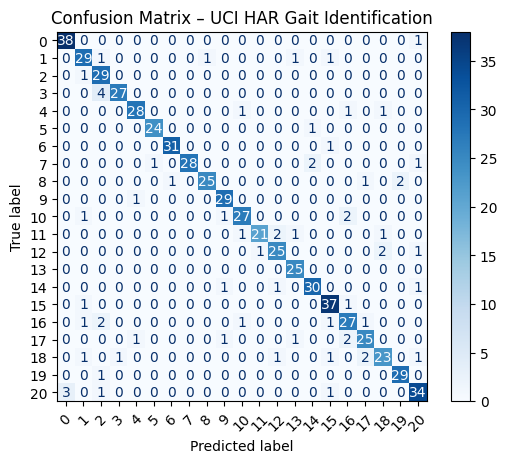

In [ ]:
##Confusion Matrix

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)

plt.title("Confusion Matrix – UCI HAR Gait Identification")
plt.show()
